# Cornell Demo
DB Seminar, Spring 2022.
Rolando Garcia, UC Berkeley.
rogarcia@berkeley.edu

# <- What's in the repo?
0. This is a vanilla Jupyter Notebook, running on VSCode
1. Show README
2. Let's see some code

# -> Lets see train_rnn.py

We can also characterize the train_rnn.py code as follows:
```python
import flor
import torch

trainloader: torch.utils.data.DataLoader
testloader:  torch.utils.data.DataLoader
optimizer:   torch.optim.Optimizer
net:         torch.nn.Module
criterion:   torch.nn._Loss

for epoch in flor.it(range(...)):
    if flor.SkipBlock.step_into('training_loop'):
        for data in trainloader:
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            print(f"loss: {loss.item()}")
    flor.SkipBlock.end(net, optimizer)
    eval(net, testloader)
```

Brief overview of Record-Replay.
* Record:
    * `flor.SkipBlock.end` serializes and writes partial checkpoint
    * auto-commit changes to repository (special branch)
* Replay:
    * `flor.it` restores its starting state from checkpoint (parallelism)
    * `flor.SkipBlock` may skip, and load side-effects instead from disk (memoization)

# "I don't want to learn a new API"
# -> flor has hands-free mode
Side-by-side comparison. I want to show you what I'm doing.
```bash
python -c "import flor; flor.transformer.Transform('...')
```

# "I don't want this to slow training"
# -> Overhead is negligible
Fast Record (<6% overhead): Buffering, Write-Behind, Background Serialization/IO, Physiological Logging
![Record Plot](doc/img/record.png)
Figure from [Garcia et al. VLDB'21]

# Flor & Git
Model developers iterate quickly to try many ideas. We want to store every version of model training tried. Autocommit
* Show timeline

In [1]:
!git log

commit 4ee23a08e773c7efb3217d83bad5613df2cc20df (HEAD -> flor.shadow.alexis, origin/flor.shadow.alexis)
Author: Rolando Garcia <rogarcia@berkeley.edu>
Date:   Sat Jul 23 00:30:05 2022 +0000

    .

commit 8a8fed8200c4b2e6c22118338094a0ea597ea4f1
Author: Rolando Garcia <rogarcia@berkeley.edu>
Date:   Thu Jul 21 00:00:41 2022 +0000

    flor.shadow.alexis@kaggle-nlp-disasters-rnn::2022-07-21T00:00:05.json

commit 8073364426d41f91fedc7f8e176283ac8d72d749
Author: Rolando Garcia <rogarcia@berkeley.edu>
Date:   Wed Jul 20 23:29:12 2022 +0000

    adding demo notebook

commit 26054111a078129b57b66ca1e87868252718d90f
Author: codespace <codespace@codespaces_01f164>
Date:   Thu Feb 17 10:19:34 2022 +0000

    flor.shadow.alexis@kaggle-nlp-disasters-rnn::2022-02-17T10:18:37.json

commit 87f281a97ce56c135c7092f867affa2a22622bc1
Author: Alexis Wan <60990214+alexiswan99@users.noreply.github.com>
Date:   Thu Feb 17 10:16:27 2022 +0000

    save

commit f021804ff8e643be1dace2638f3c64a50c146578
Author:

In [2]:
!git branch

  flor.shadow
* flor.shadow.alexis


# Let's explore the Model Training History
Exploratory model development

In [3]:
import flor
import numpy as np

Fact table with all the data logged so far:

In [4]:
raw_df = flor.load_kvs()
raw_df

,projid,vid,tstamp,alpha,epoch,step,name,value
38970,kaggle-nlp-disasters-rnn,6daf42f49c303d44ae7e86160ff9fff31b18ce62,2022-02-01 23:50:45,a,1,0,avg_train_loss,0.687694
38972,kaggle-nlp-disasters-rnn,6daf42f49c303d44ae7e86160ff9fff31b18ce62,2022-02-01 23:50:45,a,1,0,average_valid_loss,0.668976
38971,kaggle-nlp-disasters-rnn,6daf42f49c303d44ae7e86160ff9fff31b18ce62,2022-02-01 23:50:45,a,1,1,avg_train_loss,0.674396
38973,kaggle-nlp-disasters-rnn,6daf42f49c303d44ae7e86160ff9fff31b18ce62,2022-02-01 23:50:45,a,1,1,average_valid_loss,0.656242
38974,kaggle-nlp-disasters-rnn,6daf42f49c303d44ae7e86160ff9fff31b18ce62,2022-02-01 23:50:45,a,2,0,avg_train_loss,0.644441
...,...,...,...,...,...,...,...,...
10609,kaggle-nlp-disasters-rnn,891435432eb68ca13e41a34b2c64a796109719d0,2022-02-10 03:31:32,b,79,1,learning_rate,0.100178
10444,kaggle-nlp-disasters-rnn,891435432eb68ca13e41a34b2c64a796109719d0,2022-02-10 03:31:32,a,80,0,avg_train_loss,0.502675
10446,kaggle-nlp-disasters-rnn,891435432eb68ca13e41a34b2c64a796109719d0,2022-02-10 03:31:32,a,80,0,average_valid_loss,0.506836
10445,kaggle-nlp-disasters-rnn,891435432eb68ca13e41a34b2c64a796109719d0,2022-02-10 03:31:32,a,80,1,avg_train_loss,0.520349


### -> The table is populated with logged data
Let's see the logging statements in train_rnn.py

In [7]:
df = raw_df[['vid', 'tstamp', 'epoch', 'step', 'name', 'alpha', 'value']]
df

,vid,tstamp,epoch,step,name,alpha,value
38970,6daf42f49c303d44ae7e86160ff9fff31b18ce62,2022-02-01 23:50:45,1,0,avg_train_loss,a,0.687694
38972,6daf42f49c303d44ae7e86160ff9fff31b18ce62,2022-02-01 23:50:45,1,0,average_valid_loss,a,0.668976
38971,6daf42f49c303d44ae7e86160ff9fff31b18ce62,2022-02-01 23:50:45,1,1,avg_train_loss,a,0.674396
38973,6daf42f49c303d44ae7e86160ff9fff31b18ce62,2022-02-01 23:50:45,1,1,average_valid_loss,a,0.656242
38974,6daf42f49c303d44ae7e86160ff9fff31b18ce62,2022-02-01 23:50:45,2,0,avg_train_loss,a,0.644441
...,...,...,...,...,...,...,...
10609,891435432eb68ca13e41a34b2c64a796109719d0,2022-02-10 03:31:32,79,1,learning_rate,b,0.100178
10444,891435432eb68ca13e41a34b2c64a796109719d0,2022-02-10 03:31:32,80,0,avg_train_loss,a,0.502675
10446,891435432eb68ca13e41a34b2c64a796109719d0,2022-02-10 03:31:32,80,0,average_valid_loss,a,0.506836
10445,891435432eb68ca13e41a34b2c64a796109719d0,2022-02-10 03:31:32,80,1,avg_train_loss,a,0.520349


In [9]:
record_df = df[['tstamp', 'epoch', 'step', 'name', 'value']][df['alpha'] == 'a']
replay_df = df[['tstamp', 'epoch', 'step', 'name', 'value']][df['alpha'] == 'b']
record_df['name'].unique(), replay_df['name'].unique() # What did I log in the past? What did the other students log?

(array(['avg_train_loss', 'average_valid_loss', 'best_acc', 'best_loss',
        'hindsight-logged-val'], dtype=object),
 array(['best_acc', 'best_loss', 'device', 'optimizer', 'learning_rate'],
       dtype=object))

In [10]:
# import plotly.express as px

df = record_df
avg_train_loss = df[df['name'] == 'avg_train_loss']
avg_train_loss_agg = avg_train_loss.groupby(['tstamp', 'epoch']).agg({'value': 'mean'}).reset_index()
avg_train_loss_agg['tstamp'] = avg_train_loss_agg['tstamp'].map(str)
avg_train_loss_agg # Rollup
# fig = px.line_3d(avg_train_loss_agg, x='tstamp', y='epoch', z='value', color='tstamp')
# fig.show()

,tstamp,epoch,value
0,2022-02-01 23:50:45,1,0.681045
1,2022-02-01 23:50:45,2,0.645174
2,2022-02-01 23:50:45,3,0.596503
3,2022-02-01 23:50:45,4,0.541872
4,2022-02-01 23:50:45,5,0.494831
...,...,...,...
8815,2022-02-10 03:31:32,76,0.504667
8816,2022-02-10 03:31:32,77,0.510805
8817,2022-02-10 03:31:32,78,0.498961
8818,2022-02-10 03:31:32,79,0.513081


In [11]:
import matplotlib.pyplot as plt

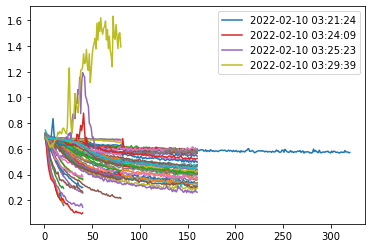

In [12]:
# %matplotlib widget
fig = plt.figure()
ax = plt.subplot()
for t in avg_train_loss_agg['tstamp'].drop_duplicates().values:
    df = avg_train_loss_agg[avg_train_loss_agg['tstamp'] == t]
    if any(df['value'] > 0.8):
        ax.plot(df['epoch'], df['value'], label=t)
    else:
        ax.plot(df['epoch'], df['value'])
ax.legend()
plt.show()



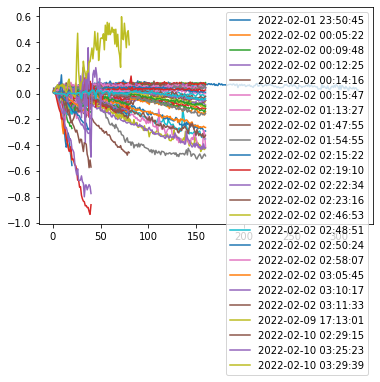

In [13]:
# %matplotlib widget
df = record_df
avg_val_loss = df[df['name'] == 'average_valid_loss']
avg_valid_loss_agg = avg_val_loss.groupby(['tstamp', 'epoch']).agg({'value': 'mean'}).reset_index()
avg_valid_loss_agg['tstamp'] = avg_valid_loss_agg['tstamp'].map(str)
avg_valid_loss_agg

m_df =  avg_train_loss_agg.merge(avg_valid_loss_agg, on=['tstamp', 'epoch'])
m_df['diff'] = m_df['value_x'] - m_df['value_y']                                # train_loss - val_loss
m_df

fig = plt.figure()
ax = plt.subplot()
for t in m_df['tstamp'].drop_duplicates().values:
    df = m_df[m_df['tstamp'] == t]
    if any(df['diff'].map(abs) > 0.19):
        ax.plot(df['epoch'], df['diff'], label=t)
    else:
        ax.plot(df['epoch'], df['diff'], label=None)
ax.legend()
plt.show()

# TODO: Start by asking queries and work back from those.

# Let's do some hindsight logging
* Skip Retraining when possible
    * Use memoization: observe physical-logical equivalence
* Parallelize Retraining otherwise
    * Enable resuming from a checkpoint
    * Work Partitioning: Control the epoch sub-range from the command-line

### -> Add print statement and replay latest version
And show mechanics of code below.
What does it do?

In [12]:
df = raw_df = flor.load_kvs()
record_df = df[['tstamp', 'epoch', 'step', 'name', 'value']][df['alpha'] == 'a']
replay_df = df[['tstamp', 'epoch', 'step', 'name', 'value']][df['alpha'] == 'b']
record_df['name'].unique(), replay_df['name'].unique() # What did I log in the past? What did the other students log?

(array(['avg_train_loss', 'average_valid_loss', 'best_acc', 'best_loss',
        'hindsight-logged-val', 'device', 'optimizer', 'learning_rate'],
       dtype=object),
 array(['optimizer', 'learning_rate', 'best_acc', 'best_loss', 'device'],
       dtype=object))

In [14]:
# Which versions have I replayed?
replay_df[replay_df['name'] == 'learning_rate']['tstamp'].unique()

array(['2022-02-10T03:25:23.000000000', '2022-02-10T03:29:39.000000000',
       '2022-02-10T03:31:32.000000000'], dtype='datetime64[ns]')

### -> Propagate logging statements back in time
And show mechanics of code below.
What does it do?

In [14]:
raw_df[['tstamp', 'vid']][
    raw_df['tstamp'] >= np.Datetime64('2022-02-10')
    ].drop_duplicates()

,tstamp,vid
5251,2022-02-10 02:29:15,e5c85b6799f23ec7ec239eb2ae621b075f8933cd
5746,2022-02-10 03:13:05,06e583145f3b8942a216965d449e5a395b89c4a3
6076,2022-02-10 03:17:06,0ac9f4abf185c4b8cde2f0955938c66e851602c0
6406,2022-02-10 03:18:41,710c7e1edf9275df50c96de14aa5d0170ff12bc2
6736,2022-02-10 03:20:08,0a56d9d7d109bad175cd87f7c1c8674a071733d8
7066,2022-02-10 03:21:24,b1ff2adfaa917d2b5d991e072509c910d673e2a7
7396,2022-02-10 03:22:25,05751709ecb8adeaa4b2589bfe8598039f185e33
7726,2022-02-10 03:23:19,b1c1e7d3f37c819867baec0b51864c253cdf480f
8056,2022-02-10 03:24:09,9a517185de46fc5d93bb5bb233500b0e446b787f
8716,2022-02-10 03:25:23,d9973057cb00a470ab29763679fd8d7f84eec1b0


In [ ]:
!python -m flor stage train_rnn.py

In [ ]:
!git checkout d9973057cb00a470ab29763679fd8d7f84eec1b0

In [ ]:
!python -m flor propagate train_rnn.py

In [ ]:
!python train_rnn.py --replay_flor